## Programming Exercise 2: Logistic Regression

Done 20 Feb 17

In [108]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### 1 Logistic Regression

In [109]:
datafile = 'data/ex2data1.txt'
#!head $datafile
cols = np.loadtxt(datafile,delimiter=',',usecols=(0,1,2),unpack=True) #Read in comma separated data
# print cols[:1]
##Form the usual "X" matrix and "y" vector
X = np.transpose(np.array(cols[:-1])) #Just grab the first 2 columns, same as cols[:2]
# print X
y = np.transpose(np.array(cols[-1:]))
m = y.size # number of training examples
##Insert the usual column of 1's into the "X" matrix
X = np.insert(X,0,1,axis=1)
print X[:10]

[[  1.          34.62365962  78.02469282]
 [  1.          30.28671077  43.89499752]
 [  1.          35.84740877  72.90219803]
 [  1.          60.18259939  86.3085521 ]
 [  1.          79.03273605  75.34437644]
 [  1.          45.08327748  56.31637178]
 [  1.          61.10666454  96.51142588]
 [  1.          75.02474557  46.55401354]
 [  1.          76.0987867   87.42056972]
 [  1.          84.43281996  43.53339331]]


#### 1.1 Visualizing the data

In [110]:
#Divide the sample into two: ones with positive classification, one with null classification
pos = np.array([X[i] for i in xrange(X.shape[0]) if y[i] == 1])
neg = np.array([X[i] for i in xrange(X.shape[0]) if y[i] == 0])
#Check to make sure I included all entries
#print "Included everything? ",(len(pos)+len(neg) == X.shape[0])

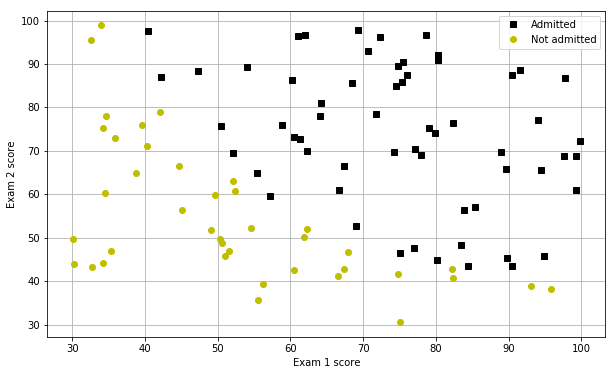

In [111]:
def plotData():
    plt.figure(figsize=(10,6))
    plt.plot(pos[:,1],pos[:,2],'ks',label='Admitted')
    plt.plot(neg[:,1],neg[:,2],'yo',label='Not admitted')
    plt.xlabel('Exam 1 score')
    plt.ylabel('Exam 2 score')
    plt.legend()
    plt.grid(True)
    
plotData()

#### 1.2 Implementation

In [112]:
from scipy.special import expit #Vectorized sigmoid function

[Expit](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.special.expit.html) is just the inverse logit function that we want. Defined as `expit(x) = 1/(1+exp(-x))`

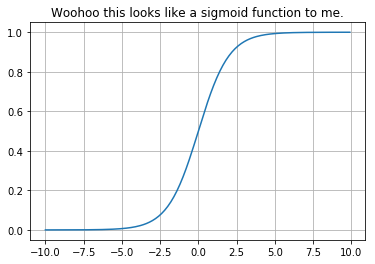

In [113]:
#Quick check that expit is what I think it is
myx = np.arange(-10,10,.1)
plt.plot(myx,expit(myx))
plt.title("Woohoo this looks like a sigmoid function to me.")
plt.grid(True)

In [114]:
#Hypothesis function and cost function for logistic regression
# Dot product just multiplies thetas by Xs and adds them into the prediction Z
# expit turns that Z into the actual prediction h(x) which is (0-1)
def h(mytheta,myX): #Logistic hypothesis function
    return expit(np.dot(myX,mytheta))

#Cost function, default lambda (regularization) 0
def computeCost(mytheta,myX,myy,mylambda = 0.): 
    """
    theta_start is an n- dimensional vector of initial theta guess
    X is matrix with n- columns and m- rows
    y is a matrix with m- rows and 1 column
    Note this includes regularization, if you set mylambda to nonzero
    For the first part of the homework, the default 0. is used for mylambda
    """
    #note to self: *.shape is (rows, columns)
    #These terms are actually quite simple and calculate the cost directly
    #1: Just take the neg log of h(x) (the "raw" cost) and multiply by (dot product)
    #Y. This keeps the costs where y = 1 and drops the y = 0
    term1 = np.dot(-np.array(myy).T,np.log(h(mytheta,myX)))
    #2: Then do the converse for costs where y = 0
    term2 = np.dot((1-np.array(myy)).T,np.log(1-h(mytheta,myX)))
    
    #And this is the bonus cost term you apparently need for a regularized logit
    # lambda/2m * Sum from j = 1 to n of theta-subJ squared
    # As a derivative, lambda/m theta-subJ
    regterm = (mylambda/2) * np.sum(np.dot(mytheta[1:].T,mytheta[1:])) #Skip theta0
    
    #The cost then is just the sum of the costs where y = 1 & y = 0 averaged over the
    #size of the training set.
    return float( (1./m) * ( np.sum(term1 - term2) + regterm ) )

In [115]:
#Check that with theta as zeros, cost returns about 0.693:
initial_theta = np.zeros((X.shape[1],1))
computeCost(initial_theta,X,y)

0.6931471805599452

In [116]:
#An alternative to OCTAVE's 'fminunc' we'll use some scipy.optimize function, "fmin"
#Note "fmin" does not need to be told explicitly the derivative terms
#It only needs the cost function, and it minimizes with the "downhill simplex algorithm."
#http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.optimize.fmin.html
from scipy import optimize

def optimizeTheta(mytheta,myX,myy,mylambda=0.):
    result = optimize.fmin(computeCost, x0=mytheta, args=(myX, myy, mylambda), maxiter=400, full_output=True)
    return result[0], result[1]

#That is pretty awesome. optimize apparently lets you minimize most any function. So the 
#key to implementing logit is being sure the computeCost function is the one you want
#in that it returns the cost as a function of the same parameters passed to optimize

In [117]:
theta, mincost = optimizeTheta(initial_theta,X,y)
print theta, mincost
#That's pretty cool. Black boxes ftw

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 157
         Function evaluations: 287
[-25.16130062   0.20623142   0.20147143] 0.20349770159


In [118]:
#"Call your costFunction function using the optimal parameters of θ. 
#You should see that the cost is about 0.203."
print computeCost(theta,X,y)

0.20349770159


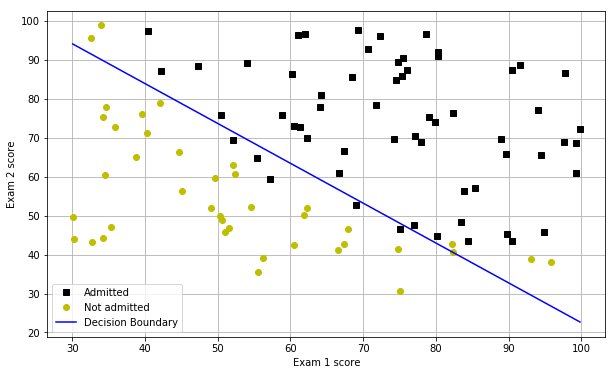

In [119]:
#Plotting the decision boundary: two points, draw a line between
#Decision boundary occurs when h = 0, or when
#theta0 + theta1*x1 + theta2*x2 = 0
#y=mx+b is replaced by x2 = (-1/thetheta2)(theta0 + theta1*x1)

#This just grabs the max/min values to plot 2 points on the x-axis
boundary_xs = np.array([np.min(X[:,1]), np.max(X[:,1])])
#Then use the algebraic rearrangement of the linear prediction to output
#a vector of the 2 y-values at those edges.
boundary_ys = (-1./theta[2])*(theta[0] + theta[1]*boundary_xs)
plotData() #Just replot the main graph we conveniently saved as a function above
plt.plot(boundary_xs,boundary_ys,'b-',label='Decision Boundary')
plt.legend()

In [120]:
#For a student with an Exam 1 score of 45 and an Exam 2 score of 85, 
#you should expect to see an admission probability of 0.776.
print theta
print theta.shape
print h(theta,np.array([1, 45.,85.]))

#Here I'm just playing with matrix dimensions again. The final theta gets output as a scalar.
#But initial_theta was a vector
print initial_theta
print initial_theta.shape
#So you get a vector out using h(x) that way
print h(initial_theta,np.array([1, 45.,85.]))
#After some tinkering, this slice works. Takes all the rows and forces "0" columns
#ie it turns the vector into a scalar
print initial_theta[:,0]

#And so, finally, you get scalar output
print h(initial_theta[:,0],np.array([1, 45.,85.]))
print h(np.array([0,0,0]),np.array([1, 45.,85.]))

[-25.16130062   0.20623142   0.20147143]
(3,)
0.776291590411
[[ 0.]
 [ 0.]
 [ 0.]]
(3, 1)
[ 0.5]
[ 0.  0.  0.]
0.5
0.5


NB: In the test above with h(x) using initial_theta, the result is 0.5. This is as expected. If thetas are all 0, then the x terms drop out of the prediction. Theta = 0 implies this value of x is totally uncorrelated to the prediction. So if all the thetas are x, you have a bunch of x values that predict nothing, and so the probability is always a coin flip. It's like having a bunch of stockmarket data to predict a coin flip or a quantum phenomenon.

In [121]:
def makePrediction(mytheta, myx):
    print h(mytheta,myx) >= 0.5
    return h(mytheta,myx) >= 0.5
#NB: This doesn't take the confidence into account. It's just the forced guess.
#If h(x) > 0.5, even if it was 0.500001, that's a predicted positive.

#Compute the percentage of samples I got correct:
#(way up on ~ln 13, we had split the training set into pos & neg)
pos_correct = float(np.sum(makePrediction(theta,pos)))
neg_correct = float(np.sum(np.invert(makePrediction(theta,neg))))
tot = len(pos)+len(neg)
prcnt_correct = float(pos_correct+neg_correct)/tot
print "Fraction of training samples correctly predicted: %f." % prcnt_correct 

### 2 Regularized Logistic Regression

[ True  True  True False  True  True  True  True  True False  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True False  True]
[False False False False  True False False False False False False  True
 False False False False False  True False False False  True False False
 False False False  True False False False False False False False False
  True False False False]
Fraction of training samples correctly predicted: 0.890000.


#### 2.1 Visualizing the data

In [122]:
datafile = 'data/ex2data2.txt'
#!head $datafile
cols = np.loadtxt(datafile,delimiter=',',usecols=(0,1,2),unpack=True) #Read in comma separated data
##Form the usual "X" matrix and "y" vector
X = np.transpose(np.array(cols[:-1]))
y = np.transpose(np.array(cols[-1:]))
m = y.size # number of training examples
##Insert the usual column of 1's into the "X" matrix
X = np.insert(X,0,1,axis=1)

In [123]:
#Divide the sample into two: ones with positive classification, one with null classification
pos = np.array([X[i] for i in xrange(X.shape[0]) if y[i] == 1])
neg = np.array([X[i] for i in xrange(X.shape[0]) if y[i] == 0])
#Check to make sure I included all entries
#print "Included everything? ",(len(pos)+len(neg) == X.shape[0])

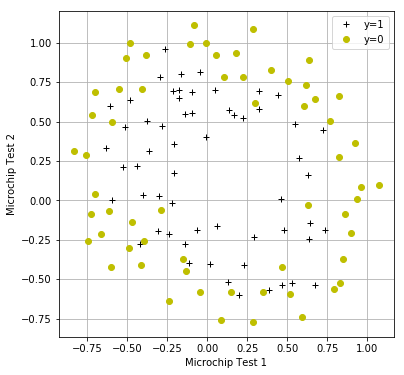

In [124]:
def plotData():
    plt.plot(pos[:,1],pos[:,2],'k+',label='y=1')
    plt.plot(neg[:,1],neg[:,2],'yo',label='y=0')
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')
    plt.legend()
    plt.grid(True)

#Draw it square to emphasize circular features
plt.figure(figsize=(6,6))
plotData()

#### 2.2 Feature mapping

Don't sweat this code too much. Ng's notes just invoke it without explaining much, but the concept is straight forward. For this dataset, a linear decision boundary will work poorly. This code just expands the training set to include all the higher order polynomials of x1, x2 up to the 6th power. This lets you solve for thetas of all those combos and so can come up with a non-linear decision boundary.

In [125]:
#This code I took from someone else (the OCTAVE equivalent was provided in the HW)
def mapFeature( x1col, x2col ):
    """ 
    Function that takes in a column of n- x1's, a column of n- x2s, and builds
    a n- x 28-dim matrix of features as described in the homework assignment
    """
    degrees = 6
    out = np.ones( (x1col.shape[0], 1) )

    for i in range(1, degrees+1):
        for j in range(0, i+1):
            term1 = x1col ** (i-j)
            term2 = x2col ** (j)
            term  = (term1 * term2).reshape( term1.shape[0], 1 ) 
            out   = np.hstack(( out, term ))
    return out

In [126]:
#Create feature-mapped X matrix
mappedX = mapFeature(X[:,1],X[:,2])
print X.shape
print X[:3]
print mappedX.shape
#Note the first 3 columns of each row are the same. They're x0 (ie 1), x1 & x2 
#without any powers
print mappedX[:3]

(118, 3)
[[ 1.        0.051267  0.69956 ]
 [ 1.       -0.092742  0.68494 ]
 [ 1.       -0.21371   0.69225 ]]
(118, 28)
[[  1.00000000e+00   5.12670000e-02   6.99560000e-01   2.62830529e-03
    3.58643425e-02   4.89384194e-01   1.34745327e-04   1.83865725e-03
    2.50892595e-02   3.42353606e-01   6.90798869e-06   9.42624411e-05
    1.28625106e-03   1.75514423e-02   2.39496889e-01   3.54151856e-07
    4.83255257e-06   6.59422333e-05   8.99809795e-04   1.22782870e-02
    1.67542444e-01   1.81563032e-08   2.47750473e-07   3.38066048e-06
    4.61305487e-05   6.29470940e-04   8.58939846e-03   1.17205992e-01]
 [  1.00000000e+00  -9.27420000e-02   6.84940000e-01   8.60107856e-03
   -6.35227055e-02   4.69142804e-01  -7.97681228e-04   5.89122275e-03
   -4.35092419e-02   3.21334672e-01   7.39785525e-05  -5.46363780e-04
    4.03513411e-03  -2.98012201e-02   2.20094970e-01  -6.86091891e-06
    5.06708697e-05  -3.74226408e-04   2.76382476e-03  -2.04120477e-02
    1.50751849e-01   6.36295342e-07  -4.

#### 2.3 Cost function and gradient

In [127]:
#Cost function is the same as the one implemented above, as I included the regularization
#toggled off for default function call (lambda = 0)
#I do not need separate implementation of the derivative term of the cost function
#Because the scipy optimization function I'm using only needs the cost function itself
#Let's check that the cost function returns a cost of 0.693 with zeros for initial theta,
#and regularized x values
initial_theta = np.zeros((mappedX.shape[1],1))
print initial_theta.shape
computeCost(initial_theta,mappedX,y)

(28, 1)


0.6931471805599453

##### 2.3.1 Learning parameters using fminunc

In [133]:
#I noticed that fmin wasn't converging (passing max # of iterations)
#so let's use minimize instead
#https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize

def optimizeRegularizedTheta(mytheta,myX,myy,mylambda):
    result = optimize.minimize(computeCost, mytheta, args=(myX, myy, mylambda),  method='BFGS', options={"maxiter":500, "disp":False} )
    return np.array([result.x]), result.fun
    
theta, mincost = optimizeRegularizedTheta(initial_theta,mappedX,y,0)
print theta, mincost

[[   27.50686392    42.90485727    35.1824809   -278.39044433
   -135.03845891  -131.33684568  -312.16324075  -395.55712495
   -258.74312765  -114.31984353   945.36470874   912.55261951
   1219.65842841   519.70687506   239.61402999   528.51168231
    972.78534298  1157.88621399   832.69567696   343.20176498
    112.82086062 -1063.09030693 -1612.60261606 -2543.43932436
  -2013.42785359 -1616.98193483  -601.50021436  -178.95083498]] 0.23825992878


#### 2.4 Plotting the decision boundary

In [134]:
def plotBoundary(mytheta, myX, myy, mylambda):
    """
    Function to plot the decision boundary for arbitrary theta, X, y, lambda value
    Inside of this function is feature mapping, and the minimization routine.
    It works by making a grid of x1 ("xvals") and x2 ("yvals") points,
    And for each, computing whether the hypothesis classifies that point as
    True or False. Then, a contour is drawn with a built-in pyplot function.
    """
    #Run the minimization
    theta, mincost = optimizeRegularizedTheta(mytheta,myX,myy,mylambda)
    #Get 2 vectors for x, y values to plot
    xvals = np.linspace(-1,1.5,50)
    yvals = np.linspace(-1,1.5,50)
    #Prep an empty matrix for the Z corresponding to those x, y pairs
    zvals = np.zeros((len(xvals),len(yvals)))
    for i in xrange(len(xvals)):
        #for each x,y combo:
        for j in xrange(len(yvals)):
            #Run that 28 dimensional feature set to get the higher order polynomials
            myfeaturesij = mapFeature(np.array([xvals[i]]),np.array([yvals[j]]))
            #Logit prediction - just take the dot product of theta & the polynomials
            zvals[i][j] = np.dot(theta,myfeaturesij.T)
    zvals = zvals.transpose()

    u, v = np.meshgrid( xvals, yvals ) #I don't think this is doing anything here
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html
    mycontour = plt.contour( xvals, yvals, zvals, [0])
    #Kind of a hacky way to display a text on top of the decision boundary
    myfmt = { 0:'Lambda = %d'%mylambda}
    plt.clabel(mycontour, inline=1, fontsize=15, fmt=myfmt)
    plt.title("Decision Boundary")

This last batch of graphs is producing different output when I run it, with or without my modifications. Seems something in the code base must have changed. The original graps are in `differentLambdas.png`
It also seems mighty odd that it only plots for lambda = 0

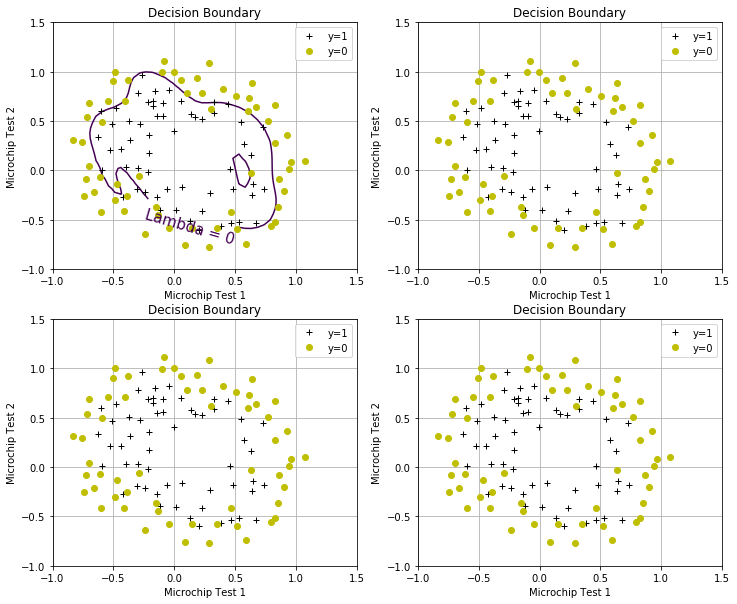

In [141]:
#Build a figure showing contours for various values of regularization parameter, lambda
#It shows for lambda=0 we are overfitting, and for lambda=100 we are underfitting
plt.figure(figsize=(12,10))
plt.subplot(221)
plotData()
plotBoundary(theta,mappedX,y,0)

plt.subplot(222)
plotData()
plotBoundary(theta,mappedX,y,1.)

plt.subplot(223)
plotData()
plotBoundary(theta,mappedX,y,10.)

plt.subplot(224)
plotData()
plotBoundary(theta,mappedX,y,100.)